### Project Title:

Comparison of two types of autoencoders in reconstructing, clustering and outliers detection of crop images

### Author: Luca D'Alessandro

### Objective:

This notebook aims to compare two types of autoencoding.

The first type is a Conv2D based autoencoder in which both encoder and decoder parts are trained.\
The second uses a truncated VGG19 architecture to encode samples and a Conv2D based decoder to reconstruct the images.

The objective is to understand the potential of the two approaches in order to obtain meaningful visualization and insights from input samples

### Conclusions:

Althought the Conv2D based autoencoder leads to a better reconstruction of the original input images, (MSE ≈ 0.01 vs 0.05) the VGG19-based embeddings are better at explaining variation of the data, leading to a more meaningful visualization, clustering and outlier detection.



## Get permission to download data from Kaggle

In [ ]:
from google.colab import files

files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
 !chmod 600 ~/.kaggle/kaggle.json

## Download and unzip data

In [7]:
!kaggle datasets download -d mdwaquarazam/agricultural-crops-image-classification

Dataset URL: https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification
License(s): CC0-1.0


In [ ]:
!unzip agricultural-crops-image-classification.zip

## Import useful modules

In [9]:
import cv2 as cv
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Conv2D, GlobalMaxPool2D, BatchNormalization, Dense, MaxPooling2D, Dropout,\
                                    Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil

## Detect and remove non compatible images

In [10]:
from pathlib import Path
import imghdr

# detect

data_dir = "/content/Agricultural-crops"
image_extensions = [".png", ".jpg", ".jpeg"]  # add here all your images file extensions
not_accepted = []
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            not_accepted.append(filepath)

/content/Agricultural-crops/tomato/image (10).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/jowar/image (1).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/jowar/image (21).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/jowar/image (20).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/cotton/image (31).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/vigna-radiati(Mung)/image (7).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/vigna-radiati(Mung)/image (6).jpg is a webp, not accepted by TensorFlow
/content/Agricultural-crops/wheat/image (34).jpg is a webp, not accepted by TensorFlow


<ipython-input-10-3aa13ca759e0>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [11]:
# remove

for i in range(len(not_accepted)):
  os.remove(not_accepted[i])

## Resize images and structure them in array fashion (inputs and labels)

In [12]:
data = []
y = []

# originally, data are structured in subdirectories.
# Each subdirectory name represents the label.

for subdir in os.listdir("Agricultural-crops"):
  for img in os.listdir(f"Agricultural-crops/{subdir}"):
    img_path = f"Agricultural-crops/{subdir}/{img}"
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (200,200))
    data.append(img)
    y.append(subdir)
data = np.array(data)

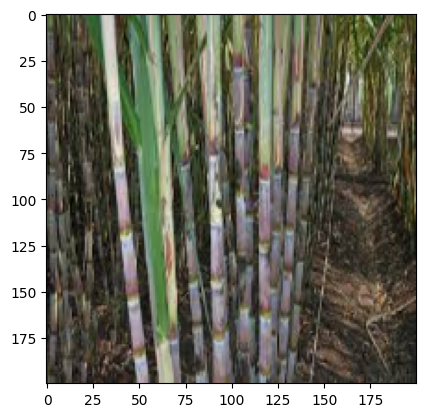

In [13]:
plt.imshow(data[0])

## Split data in train and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

In [16]:
# check data shape

X_train.shape

(656, 200, 200, 3)

In [17]:
# check number of labels

len(np.unique(y_test))

30

## Normalize pixels

In [18]:
X_train = X_train.reshape(-1,200,200,3)
X_test = X_test.reshape(-1,200,200,3)

X_train = X_train / 255
X_test = X_test / 255

In [19]:
X_train.shape

(656, 200, 200, 3)

In [20]:
print(X_train.shape)
print(X_test.shape)

(656, 200, 200, 3)
(165, 200, 200, 3)


## Autoencoder n. 1: Conv2d based

In [21]:
i = Input(shape=X_train.shape[1:])
#encoder
x = Conv2D(32, (3,3), activation="relu", padding="same")(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding="same")(x)

#decoder
x = Conv2DTranspose(32, (3,3), strides=4, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

cnn_autoencoder = Model(i,x)
cnn_autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 100, 100, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 200, 200, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,395 (153.89 KB)

 Trainable params: 39,075 (152.64 KB)

 Non-trainable params: 320 (1.25 KB)

In [22]:
cnn_autoencoder.compile(optimizer="adam", loss="mse")

In [23]:
early_stop = EarlyStopping(monitor="val_loss", patience=3)

In [24]:
r_cnn = cnn_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test),callbacks=[early_stop])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - loss: 0.0889 - val_loss: 0.0679
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0314 - val_loss: 0.0648
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0242 - val_loss: 0.0645
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0208 - val_loss: 0.0630
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0182 - val_loss: 0.0611
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0169 - val_loss: 0.0599
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0160 - val_loss: 0.0564
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0160 - val_loss: 0.0539
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0144 - val_loss: 0.0479
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0141 - val_loss: 0.0447
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0136 - val_loss: 0.0386
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0

## Check reconstruction ability of a random image in the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


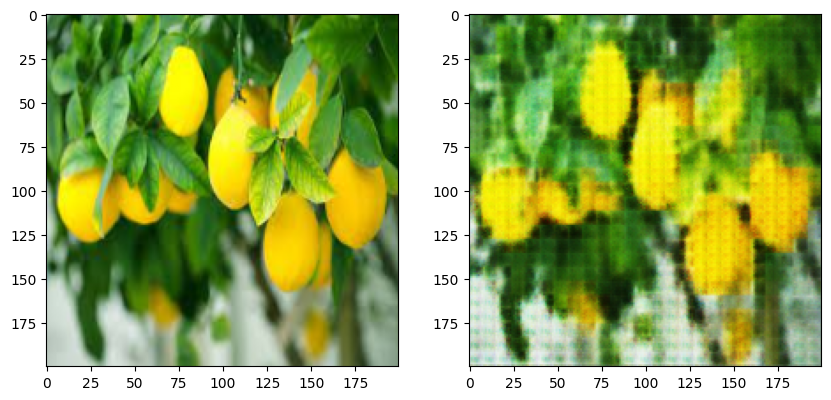

In [25]:
random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
recontructed_image = cnn_autoencoder.predict(np.expand_dims(random_image, axis=0))[0]
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(random_image)
plt.subplot(1,2,2)
plt.imshow(recontructed_image)
plt.show()

## Use the bottleneck embedding + tSNE for visualization and clustering

In [105]:
# Get the encoder part from the whole model

encoder = Model(cnn_autoencoder.input, cnn_autoencoder.get_layer("max_pooling2d_2").output)

In [106]:
# use the encoder to create embeddings (2D) of the train images

X_enc = encoder.predict(X_train)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [107]:
# flatten the embeddings to make them ready for dim reduction

flatten  = Flatten()
X_enc = flatten(X_enc)

In [108]:
from sklearn.manifold import TSNE
import matplotlib
X_red = TSNE(n_components=2).fit_transform(X_enc)

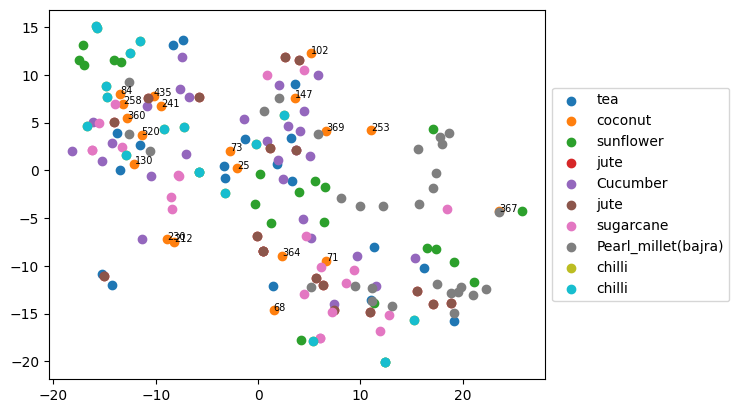

In [109]:
# Let's use 10 random classes to be represented

#select 10 colors
colors = plt.get_cmap('tab10').colors

# select 10 random classes
labels = np.unique(y_train)
label_index = np.random.choice(range(0,30), 10)
random_labels = labels[label_index]

y_train = np.array(y_train)

for l,c in zip(random_labels,colors):
  idxs = np.where(y_train==l)[0]
  X = X_red[idxs]
  plt.scatter(X[:,0], X[:,1], color=c, label=l)

  # show "coconut" class indices for further insights
  if l=="coconut":
    for i, (x,y) in zip(idxs,X):
      plt.text(x,y,str(i),fontsize=7)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Transfer Learning approach

## Autoencoder n.2: Embed data using VGG19 body

In [58]:
from tensorflow.keras.applications import VGG19

# Load VGG19 architecture w/o head
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(200,200,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step


In [61]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Embed train and test data
X_vgg_train = vgg.predict(X_train)
X_vgg_test = vgg.predict(X_test)
print(X_vgg_train.shape)
print(X_vgg_test.shape)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step
(656, 6, 6, 512)
(165, 6, 6, 512)


In [67]:
# Reshape embeddings in order to be able to reconstruct images at original shape
X_vgg_train = np.array([cv.resize(x_vgg, (5,5)) for x_vgg in X_vgg_train])
X_vgg_test = np.array([cv.resize(x_vgg, (5,5)) for x_vgg in X_vgg_test])
print(X_vgg_train.shape)
print(X_vgg_test.shape)

(656, 5, 5, 512)
(165, 5, 5, 512)


In [68]:
#decoder
i = Input(shape=X_vgg_train.shape[1:])
x = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(i)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (4,4), strides=2, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3,3), strides=5, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

vgg_decoder = Model(i,x)
vgg_decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 10, 10, 32)     │       147,488 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 20, 20, 32)     │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 100, 100, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 200, 200, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 200, 200, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,779 (717.89 KB)

 Trainable params: 183,523 (716.89 KB)

 Non-trainable params: 256 (1.00 KB)

In [69]:
vgg_decoder.compile(optimizer="adam", loss="mse")

In [70]:
r_vgg = vgg_decoder.fit(X_vgg_train, X_train, validation_data=(X_vgg_test, X_test), epochs=50, batch_size=32,callbacks=[early_stop])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 0.1062 - val_loss: 0.0735
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0744 - val_loss: 0.0702
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0658 - val_loss: 0.0683
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0587 - val_loss: 0.0683
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0568 - val_loss: 0.0678
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0529 - val_loss: 0.0671
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0529 - val_loss: 0.0662
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0505 - val_loss: 0.0658
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0495 - val_loss: 0.0651
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0486 - val_loss: 0.0631
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0488 - val_loss: 0.0611
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0

## Check reconstruction ability of a random image in the test set

In [71]:
X_dec_vgg_test = vgg_decoder.predict(X_vgg_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


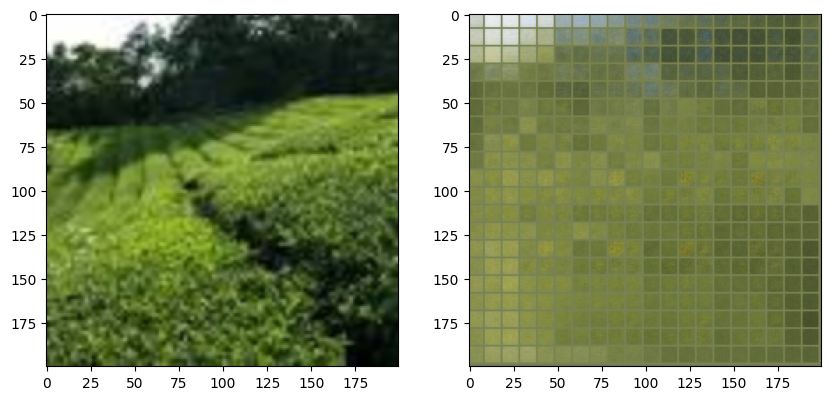

In [76]:
random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
recontructed_image = X_dec_vgg_test[random_index]
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(random_image)
plt.subplot(1,2,2)
plt.imshow(recontructed_image)
plt.show()

VGG19-based autoencoder converges to a higher MSE score compared to CNN-based autoencoder (0.04 vs 0.01). \
Moreover, it tends to build a grid when reconstructing the image.

## Use the bottleneck embedding + tSNE for visualization and clustering

In [77]:
# use the encoder to create embeddings (2D) of the train images

X_enc = vgg.predict(X_train)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step


In [78]:
# flatten the embeddings to make them ready for dim reduction

flatten  = Flatten()
X_enc = flatten(X_enc)

In [79]:
from sklearn.manifold import TSNE
import matplotlib
X_red = TSNE(n_components=2).fit_transform(X_enc)

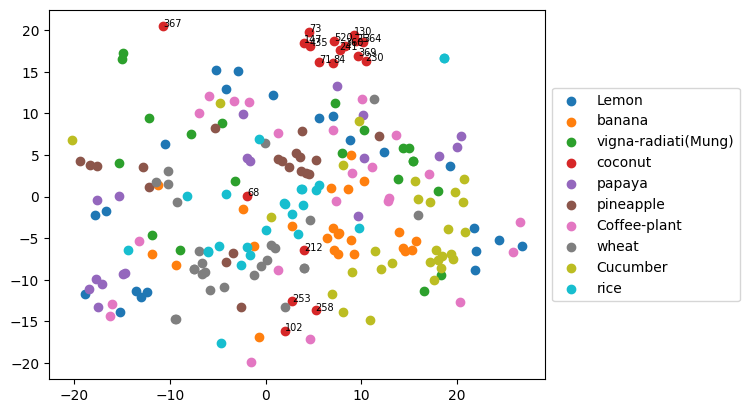

In [88]:
# Let's use 10 random classes to be represented

#select 10 colors
colors = plt.get_cmap('tab10').colors

# use same 10 random classes as before

random_labels = labels[label_index]

y_train = np.array(y_train)

for l,c in zip(random_labels,colors):
  idxs = np.where(y_train==l)[0]
  X = X_red[idxs]
  plt.scatter(X[:,0], X[:,1], color=c, label=l)

  # show "coconut" class indices for further insights
  if l=="coconut":
    for i, (x,y) in zip(idxs,X):
      plt.text(x,y,str(i),fontsize=7)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Still some data points appear to cluster accordingly to their label (banana, coconut, rice, pineapple)

For instance, let's see if there are visible differences between clustered and isolated points in the "coconut" label

In [94]:
coconut_idxs = np.where(y_train=="coconut")
coconut_isolate_idxs = np.array([367,68,212,253,258,102])
coconut_cluster_idxs = np.setdiff1d(coconut_idxs, coconut_isolate_idxs)

In [96]:
print(coconut_isolate_idxs)
print(coconut_cluster_idxs)

[367  68 212 253 258 102]
[ 25  71  73  84 130 147 230 241 360 364 369 435 520]


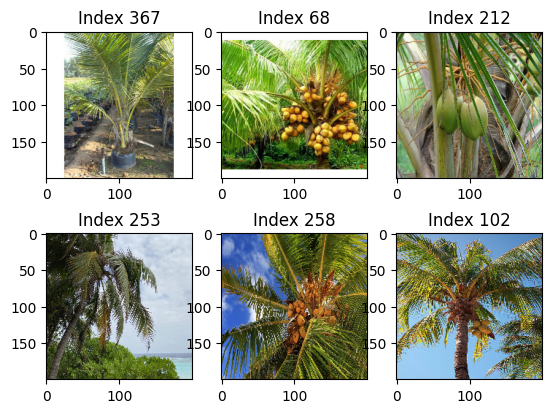

In [102]:
# Show isolated images

fig, axes = plt.subplots(2,3)
axes=axes.flatten()

for i,idx in enumerate(coconut_isolate_idxs):
  axes[i].imshow(X_train[idx])
  axes[i].set_title(f"Index {idx}")
plt.show()

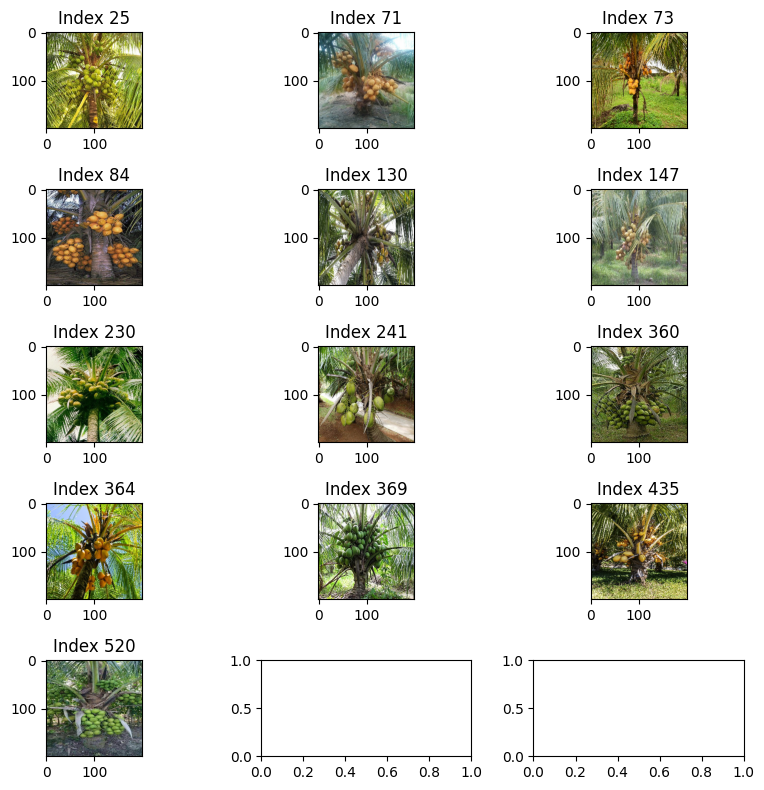

In [104]:
# Show clustered images

fig, axes = plt.subplots(5,3,figsize=(8,8))
axes=axes.flatten()

for i,idx in enumerate(coconut_cluster_idxs):
  axes[i].imshow(X_train[idx])
  axes[i].set_title(f"Index {idx}")
plt.tight_layout()
plt.show()

It seems that the images that cluster together have more evident fruits wrt images that isolate. The latter show more leaves than fruits.